#Decision Tree Classification of Real Estate Markets Across the US
This notebook analyzes housing market data accessed from zillow housing market datasets (see sources section) to build multiple decision tree models to determine if a housing market is more favorable to buyers or sellers based on local weighted inventory, metro area, and days to pending (the number of days before a seller gets an offer reasonable enough to commit to selling their property)

The goal of this project is to create a classification model that can serve as a decision tool to help a person, or company, determine if they want to sell or buy a home under current market conditions. For example, if someone is considering selling their property, they may want to wait until market conditions are favorable for a sellers to maximize the price they get for their home and minimize the time it takes to sell. If someone is wanting to buy a home they may have a more positive experience when market conditions are favorable for buyers to minimize the price they pay for a home and have a higher inventory of homes available to offer on.

This notebook, all CSV files, and a powerpoint presentatin summarizing the project can be accessed at the following public github repository:
https://github.com/arwhit/housing-markets-AdaBoost


In [1]:
#Import Required Packages
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

##Data Description
The data analyzed in this project is the combination of 3 datasets from Zillow (see sources section). Below is a brief description of each individual dataset.

**days to pending (DTP)**: This dataset is composed of historical monthly data for 775 metro areas (rows) from 08/31/2015 to 03/31/2023, 63 months (columns). In total the dataset contains 48825 numeric data points and 16829 missing values.The dataset also contains five categorical columns: RegionID, SizeRank,RegionName, RegionType, and StateName.

**Inventory (INV)**: This dataset contains historical monthly inventory data for 898 metro areas (rows) from 08/31/2015 to 03/31/2023, 63 months (columns). In total, the dataset contains 56574 numeric data points and 1254 missing values. The dataset also contains five categorical columns: RegionID, SizeRank,RegionName, RegionType, and StateName.

**Sales to List Price Ratio (STL)**: This dataset contains the monthly sell to list price ratio for 494 metro areas (rows) from 08/31/2015 to 02/28/2023, 62 months (columns). In total, the dataset contains 30628 numeric data points and 6550 missing values. The dataset also contains five categorical columns: RegionID, SizeRank,RegionName, RegionType, and StateName.

In [2]:
#Import CSV files and count missing values

#days to pending data
dtp_url="https://raw.githubusercontent.com/arwhit/housing-markets-AdaBoost/main/zillow_mean_days__to_pending17APR23.csv"
dtp_df=pd.read_csv(dtp_url)
dtp_missing=dtp_df.isna().sum().sum()
#sale to list price ratio
stl_url="https://raw.githubusercontent.com/arwhit/housing-markets-AdaBoost/main/zillow_mean_sale_to_list_ratio17APR23.csv"
stl_df=pd.read_csv(stl_url)
stl_missing=stl_df.isna().sum().sum()
#inventory by market
inv_url="https://raw.githubusercontent.com/arwhit/housing-markets-AdaBoost/main/zillow_raw_for_sale_inventory17APR23.csv"
inv_df=pd.read_csv(inv_url)
inv_missing=inv_df.isna().sum().sum()

##Data Cleaning
* The row containing the US values was dropped from each dataset as it was the 
average of all the values contained in the dataset for the given month and not meaningful for this analysis. 
* The sales to list ratio datasets is missing the last month so 03/31/2023 is dropped from the DTP and INV datasets. 
* Rows were dropped from the dataset if the metro area was not in all 3 seperate datasets.

In [3]:
#Clean and Combine Datasets

#drop the US row as it is an average of all the datapoints for the given month and not meaningful for this analysis
dtp_df.drop(index=dtp_df.index[0], axis=0, inplace=True)
inv_df.drop(index=inv_df.index[0], axis=0, inplace=True)
stl_df.drop(index=stl_df.index[0], axis=0, inplace=True)

#drop the region ID and region type columns as the will not be used, also drop the last months of data not in stl from other dataframes
dtp_df.drop(['RegionID','RegionType','2023-03-31'], axis=1, inplace=True)
inv_df.drop(['RegionID','RegionType','2023-03-31'], axis=1, inplace=True)
stl_df.drop(['RegionID','RegionType'], axis=1, inplace=True)

#retain only metros that are in all datasets
stl_metros=stl_df['RegionName'].tolist()
dtp_metros=dtp_df['RegionName'].tolist()
inv_metros=dtp_df['RegionName'].tolist()
dtp_df=dtp_df.loc[dtp_df['RegionName'].isin(stl_metros) & dtp_df['RegionName'].isin(inv_metros)]
inv_df=inv_df.loc[inv_df['RegionName'].isin(stl_metros) & inv_df['RegionName'].isin(dtp_metros)]
stl_df=stl_df.loc[stl_df['RegionName'].isin(dtp_metros) & stl_df['RegionName'].isin(inv_metros)]

* When combining the datasets an attempt was made to impute missing values by taking an average of the previous and next month values for the same metro area. If neighboring datapoints were missing, no estimated value was imputed.Rows in the new dataframe that still had missing values were dropped from the dataset.

* The STL Ratio was used to create a categorical market_type. If the value was greater than 1, then the response was considered a sellers market (1). If the value was less than one, then the market_type was considered a buyers market (-1).

* **After the intitial data cleaning step the combined dataframe contained 25,884 rows/samples of data and 6 columns (5 features and 1 response).**

*(Note: The categorical variables of RegionName and StateName were originally retained for visualization, but were eventually dropped for reasons discussed in the exploratory data analysis section. Inventory was also eventually replaced with a weighted inventory to the findings of EDA)*

In [4]:
#Combine into one dataframe

#counter for how many missing values were averaged
avg_count=0
#list of column names that dates will be extracted from
dates=stl_df.columns.to_list()
#Lists that will be zipped into a new datafram
SizeRank=[]
Metro=[]
State=[]
DTP=[]
INV=[]
STL=[]
Date=[]
#Iterate through the datasets and append desired values to the list
for i in range(len(stl_df)):
  SizeRank_i=stl_df.iloc[i,0]
  RegionName_i=stl_df.iloc[i,1]
  State_i=stl_df.iloc[i,2]
  for j in range(3,len(stl_df.columns)):
    #append values that are the same for the entire row
    SizeRank.append(SizeRank_i)
    Metro.append(RegionName_i)
    State.append(State_i)
    #append DTP
    dtp_ij=dtp_df.iloc[i,j]
    if dtp_ij!='':
      DTP.append(dtp_ij)
    #If values are missing, attempt to average neighboring values  
    else:
      if j==3:
        if dtp_df.iloc[i,j+1] !='': 
          DTP.append(dtp_df.iloc[i,j+1])
          avg_count+=1
        else: DTP.append(dtp_ij)
      elif j==(len(dtp_df)-1):
        if dtp_df.iloc[i,j-1] !='': 
          DTP.append(dtp_df.iloc[i,j-1])
          avg_count+=1
        else: DTP.append(dtp_ij)
      else:
        if dtp_df.iloc[i,j-1] !='' and dtp_df.iloc[i,j+1] !='':
          avg_dtp=(dtp_df.iloc[i,j-1]+dtp_df.iloc[i,j+1])/2
          DTP.append(avg_dtp)
          avg_count+=1
        else: DTP.append(dtp_ij)
    #append INV
    inv_ij=inv_df.iloc[i,j]
    if inv_ij!='':
      INV.append(inv_ij)
    #If values are missing, attempt to average neighboring values  
    else:
      if j==3:
        if inv_df.iloc[i,j+1] !='': 
          INV.append(inv_df.iloc[i,j+1])
          avg_count+=1
        else: INV.append(inv_ij)
      elif j==(len(inv_df)-1):
        if inv_df.iloc[i,j-1] !='': 
          INV.append(inv_df.iloc[i,j-1])
          avg_count+=1
        else: INV.append(inv_ij)
      else:
        if inv_df.iloc[i,j-1] !='' and inv_df.iloc[i,j+1] !='':
          avg_inv=(inv_df.iloc[i,j-1]+inv_df.iloc[i,j+1])/2
          INV.append(avg_inv)
          avg_count+=1
        else: INV.append(inv_ij)
    #Use STL to create categorical Market_Type Response variable. Possible options are a Sellers Market (1) or Buyers Market (-1)
    stl_ij=stl_df.iloc[i,j]
    if stl_ij!='':
      if stl_ij>=1:
        STL.append(1)
      else:
        STL.append(-1)
    #If values are missing, attempt to average neighboring values  
    else:
      if j==3:
        if stl_df.iloc[i,j+1] !='': 
          avg_stl=stl_df.iloc[i,j+1]
          if avg_stl>=1:
            STL.append(1)
          else:
            STL.append(-1)
          avg_count+=1
        else: STL.append(stl_ij)
      elif j==(len(stl_df)-1):
        if stl_df.iloc[i,j-1] !='': 
          avg_stl=stl_df.iloc[i,j-1]
          if avg_stl>=1:
            STL.append(1)
          else:
            STL.append(-1)
          avg_count+=1
        else: STL.append(stl_ij)
      else:
        if stl_df.iloc[i,j-1] !='' and stl_df.iloc[i,j+1] !='':
          avg_stl=(stl_df.iloc[i,j-1]+stl_df.iloc[i,j+1])/2
          if avg_stl>=1:
            STL.append(1)
          else:
            STL.append(-1)
          avg_count+=1
        else: STL.append(stl_ij)

#Create New Dataframe
d={'SizeRank':SizeRank,'Metro':Metro,'State':State,'DTP':DTP,'INV':INV,'Market_Type':STL}
df=pd.DataFrame(d)

#Drop rows that still have missing values
og_length=len(df)
df.replace('', np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
rows_dropped=og_length-len(df)
df.head()

,SizeRank,Metro,State,DTP,INV,Market_Type
0,1,"New York, NY",NY,73.0,66530.0,-1
1,1,"New York, NY",NY,68.0,74575.0,-1
2,1,"New York, NY",NY,63.0,80016.0,-1
3,1,"New York, NY",NY,65.0,86445.0,-1
4,1,"New York, NY",NY,62.0,91131.0,-1


##Exploratory Data Analysis (EDA)
Several histograms were made to analyze the dataset. Some of the key takeways were as follows:

1.   More data was available for larger metro areas which also led to states containing more metro areas having more data points available. Since states and the metro areas are closely related, it seems best to only use one in the analysis

2.   Most samples are from buyers markets, not sellers markets. This means the dataset is not balanced and extra care must be taken when creating the training and test splits. It is also likely predicitons will be better for buyers market than sellers markets.




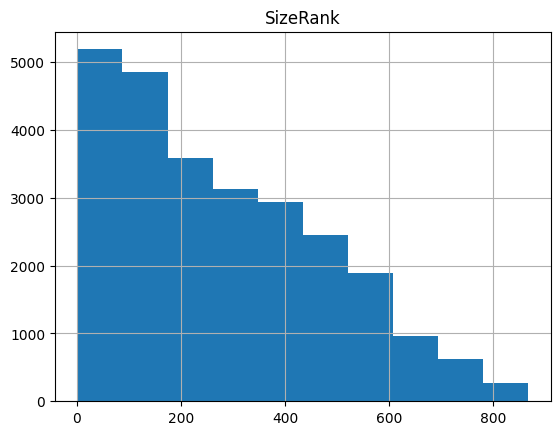

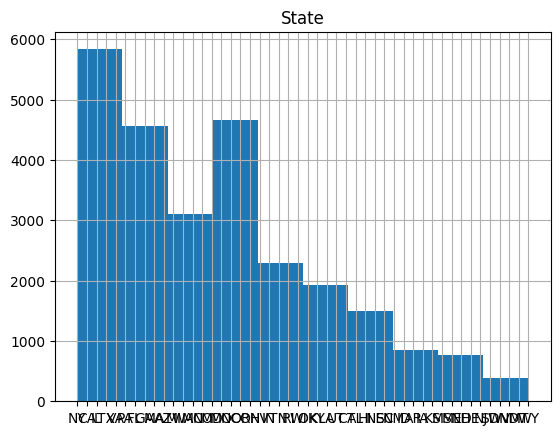

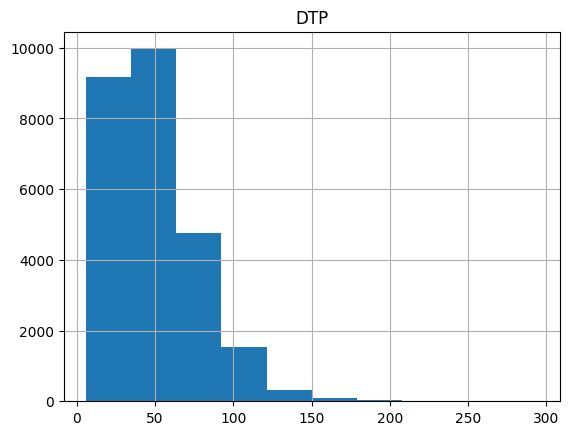

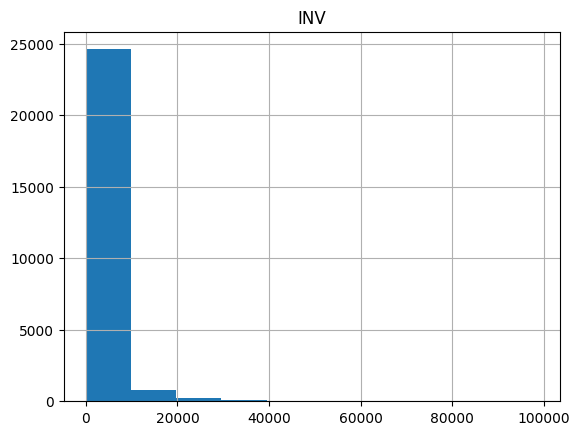

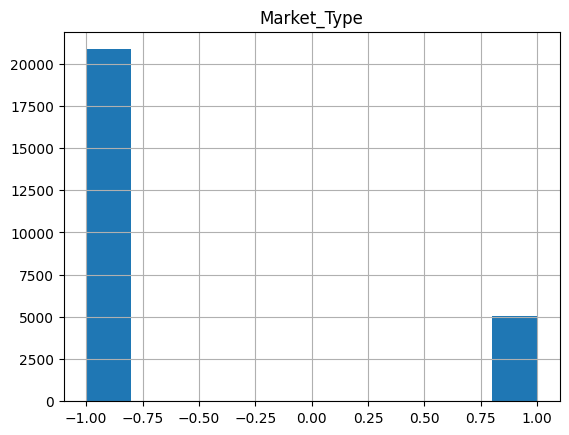

In [5]:
#Histogram
names=['SizeRank','State','DTP','INV','Market_Type']
for name in names:
  df[name].hist()
  plt.title(name)
  plt.show()

A correlation matrix was generated from the dataset. 
* It appears days to pending has a mild correlation to market type at -0.5 and size rank is weakly correlated at -0.2. 
* Inventory appears to have almost no correlation to market type. However, this could be because inventory is a raw value and not linked to the population in the area that is competing for housing. To address this a weighted inventory will be generated. 
* Overall it appears that no individual feature shows a strong correlation to each other or the response variable. This suggests a regression model will likely not be useful. It also suggests that collinearity or feature correlation will not be a concern.

<ipython-input-6-1d61c6622035>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap="Greys",linewidth=1, linecolor="black", annot=True,fmt=".1g")


<Axes: >

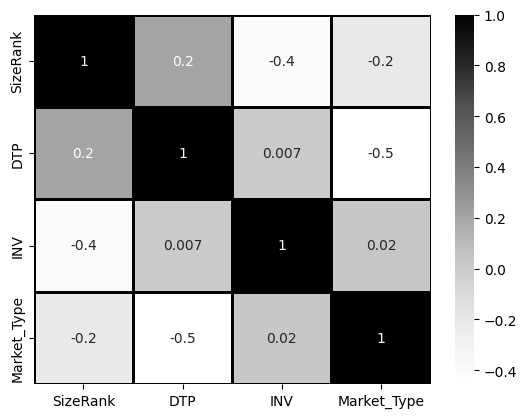

In [6]:
#Correlation Matrix Unweighted
sns.heatmap(df.corr(),cmap="Greys",linewidth=1, linecolor="black", annot=True,fmt=".1g")

A pair plot was also generated. It can be seen from the pair plot that no features appear to have linear trends and that it would be difficult to draw a decision boundry using logistical regression.

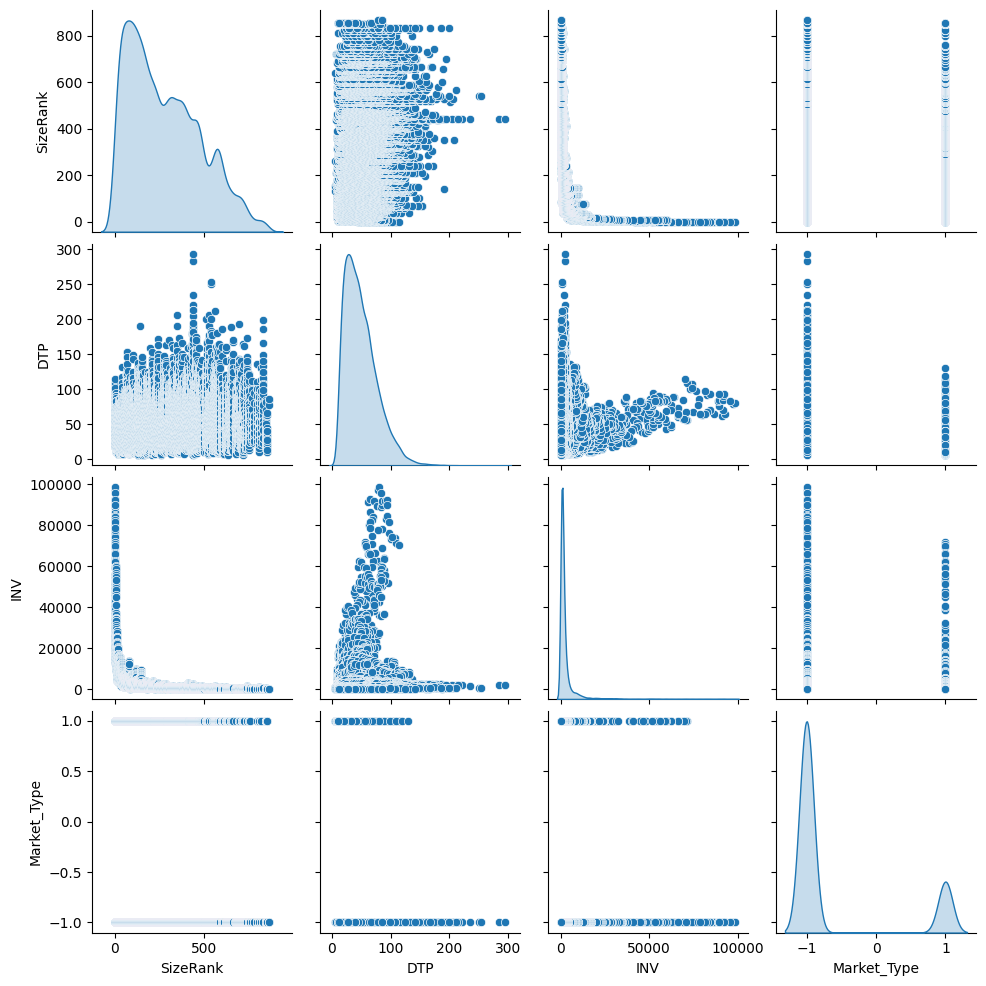

In [7]:
#Pair Plot Unweighted
sns.pairplot(df, diag_kind="kde")

To adress inventory not being reflective of individual markets, a weighted inventory was created by dividing the available inventory in an area by the market average of that area. The correlation matrix was then recreated. The correlation between the weighted inventory and Market_Type was found to be -0.3.

In [8]:
#Address inventory available by creating a weighted average for each metro area

#Create dictionary of average inventory by metro
temp_df=df.groupby('Metro',as_index=False)['INV'].mean()
avg_weight={}
for i in range(len(temp_df)):
  avg_weight[temp_df.iloc[i,0]]=temp_df.iloc[i,1]
avg_weight

#Calculate weighted invetory for each data point based on the metro average
W_INV=[]
for i in range(len(df)):
  W_INV.append(df.iloc[i,4]/avg_weight[df.iloc[i,1]])

#Add the weighted invetory to the dataframe
df['W_INV']=W_INV

<ipython-input-9-4fbf38ffca4d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),cmap="Greys",linewidth=1, linecolor="black", annot=True,fmt=".1g")


<Axes: >

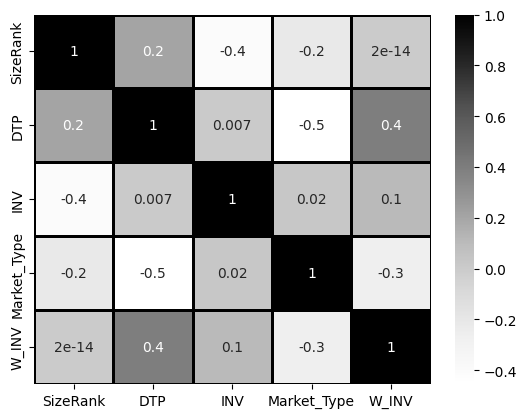

In [9]:
#Correlation Heatmap for Weighted INV
sns.heatmap(df.corr(),cmap="Greys",linewidth=1, linecolor="black", annot=True,fmt=".1g")

##Data Modeling
* Days to pending (DTP), weighted inventory (W_INV), and the SizeRank were selected as final features for modeling. The state category was dropped due to the concerns mentioned above. It was determined to leave the metro area out as the SizeRank is already set up as an ordinal encoding of each metro area. 

* Data was split into an 80/20 training and test set paying careful attention to maintain a the same ratio of buyer and seller markets since the dataset is not well balanced. 2 types of decision tree models were created, both using packages from sklearn. (A probabilistic random guess model was also created for a baseline comparison.)

* Decision tree modeling was chosen over regression as a visual inspection of the pair plot indicated a clear decision boundry likley could not be drawn. There also appeared to be no linear relationship between the features and response. The first model was a simple decision tree classifier. To address overfitting and overall performance an ensembling method, AdaBoost, was used with hyperparmeter tuning to build an additional models.

In [10]:
#Split into a training and test set, use stratify to ensure ratio of repsonses are the same in each split
X=df[['DTP','W_INV','SizeRank']]
y=df['Market_Type']
X_train,X_test,y_train,y_test=sk.model_selection.train_test_split(X, y, test_size = 0.2 ,random_state = 5, stratify=y)

### Simple Decision Tree
The first model was a simple decision tree classifier. It was built and fit to the training data using the sklearn.tree package (see sources section). Gini was used as the splitting criterion. By extracting the feature importance from the model we see that days to pending appears to be the most important feature, being uses as the feature for splitting almost 50% of the time whereas weighted inventory and SizeRank are used as the splitting criteria about 25% of the time each. The simple decision tree has a depth of 32 and 5199 nodes. This in conjuction with a visual inspection of the decision tree suggests their might be some overfitting, but we will check this is the results and analysis section.

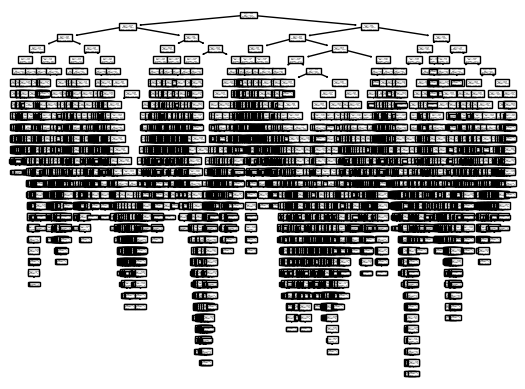

In [11]:
#Build regular decision tree
simple_dt=sk.tree.DecisionTreeClassifier(random_state=5).fit(X_train,y_train)
sklearn.tree.plot_tree(simple_dt)
plt.show()

In [12]:
#Extract the features importance from the model recall feature order in X (DTP, W_INV, SizeRank)
print('The feature importance of the model is as follows: ', simple_dt.feature_importances_)
print('The decision tree has a depth of', simple_dt.tree_.max_depth,' and ', simple_dt.tree_.node_count,' nodes')

The feature importance of the model is as follows:  [0.47907638 0.23687059 0.28405304]
The decision tree has a depth of 32  and  5197  nodes


### AdaBoost Tree (Ensemble Method)
* AdaBoosting, an ensemble method, was conducted using the sklearn.ensemble package (see soruces section). 
* GridSearch CV was used for cross validation and hyperparameter tuning. Several models were made with the number of estimators, max tree depth of the weak learner, and learning rate varied for hypertuning. **It is important to note that F1 score, not accuracy, was used as a scoring method. F1 was used due to the inbalance in the dataset. Since there is only a small number of true positives, we prioritze a scoring method that heavily weights the identification of true positives.**

In [13]:
#Build adaBoost classifier on training data
ada_params=dict()
ada_params['n_estimators']=[50,100]
ada_params['learning_rate']=[0.1,0.5,1]
ada_params['estimator']=[sk.tree.DecisionTreeClassifier(max_depth=1),sk.tree.DecisionTreeClassifier(max_depth=3),sk.tree.DecisionTreeClassifier(max_depth=5)]
ada_grid=sk.model_selection.GridSearchCV(sk.ensemble.AdaBoostClassifier(random_state=5),param_grid=ada_params,scoring='recall').fit(X_train, y_train)
adatree=sk.ensemble.AdaBoostClassifier(estimator=ada_grid.best_params_['estimator'],n_estimators=ada_grid.best_params_['n_estimators'], learning_rate=ada_grid.best_params_['learning_rate']).fit(X_train,y_train)

After conducting a gridsearch to tune the hyperparameters, it was found the best combination of estimators was: max_depth=5, learning_rate=0.5, and n_estimators=100. Extracting the feature importance from the model we see that SizeRank is the most important feature for the ensemble method followed by the weighted inventory, then days to pending.

In [14]:
print('The best Parameters for the AdaBoost Classifier are: ', ada_grid.best_params_)

The best Parameters for the AdaBoost Classifier are:  {'estimator': DecisionTreeClassifier(max_depth=5), 'learning_rate': 0.5, 'n_estimators': 100}


In [15]:
#Extract the features importancce from the model recall feature order in X (DTP, W_INV, SizeRank)
adatree.feature_importances_

array([0.20774863, 0.35912199, 0.43312938])

##Results and Analysis
* Now it is time to analyze the results of each model. For this we will predict the results from the test dataset using the models trainined in the previous section and compare them to radomly assigning a market_type based on the probability of the response alone (zero features)
* Confusion Matrices were created and visualized as a heatmap for each model. As a reminder, sklearn documentation defines a confusion matrix as: "A confusion matrix, $C$, is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$
and predicted to be in group $j$." In other words, the layout of the confusion matrix is as follow:

|   |   |
|---|---|
|True Negative| False Positive|
|False Negative| True Positive|

* The precision, recall, F1 score, and accuracy were calculated from the results of the confusion matrix

(Note: In our dataset a sellers market is considered to be a "positive" sample while a buyers market is considered to be a "negative" sample. This is not meant to indicate any postive or negative connotation towards buyers or seller. Positive and negative are only being used in the sense of binary classification)

### **Before we deep dive into the analysis, let's consider what precision, recall, F1 score and accuracy mean in the context of the dataset and the impact wrong predictions.**

|Metric|Desription|
|---|---|
|Precision|What ratio of predicted sellers markets were actually sellers markets?|
|Recall|What ratio of real world sellers markets were correctly identified?|
|F1 Score|A score that attempts to balance only predicting sellers markets when it is actually a sellers market with not missing sellers markets by being too conservative|
|Accuracy|The ratio of correct predictions (both market types) to all preditions|

**Accuracy** is not a good predictor due to the imbalance of buyer and seller markets in the dataset. Accuracy can still be high even if the majority of sellers markets are misidentified, so it is not the best metric to consider.

**Precision** Precision is an important metric for this dataset. Low precision is bad because it indicates more false postives in the dataset. This is bad for sellers because they may choose to enter the market thinking they will have an easy time selling their home and may experience more difficulty than expected. Low precision is bad for buyers because they may choose to not enter the home buying market when they could easily get a home.

**Recall** Recall is also an important metric for this dataset. Low recall is bad because it indicates more false negatives in the dataset. This is bad for sellers because they may miss the oppertunity to sell their home when conditions are in their favor. This is bad for buyers because they may enter a market thinking they will find a home easily only to have a difficult time having their offer accepted.

**F1 Score** Since precision and recall are both important to the dataset, and it is difficult to say if false postives or false negatives have a more detrimental real world impact, we will consider F1 score to be the primary metric for model evaluation since it seeks to balance minimize the impact of both false postives and false negatives.

In [16]:
#Make predictions using test data
simple_tree_preds=simple_dt.predict(X_test)
adatree_preds=adatree.predict(X_test)

### The Random Baseline Model
This model was built solely on the probability that it is a buyers or sellers market from the dataset. No features were used. It was only meant to be a basline for comparison to determine if the decision tree models were actually making better predictions by considering the chosen features. The random model grossly mispredicted when it is a sellers market. Of all positive predictions, only 19.4% were actually positive, precision. Of the real positive cases, only 19.2% were identified, recall.

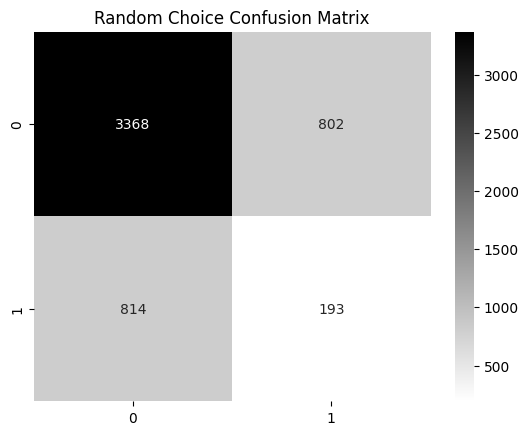

In [38]:
#Radomly assign market based on ratio of buyer/seller market without considering any features
np.random.seed(5)
true_vals=y_test.to_list()
n=len(true_vals)
random_preds=np.random.choice([-1,1], n, p=[true_vals.count(-1)/n,true_vals.count(1)/n])

random_cf=sk.metrics.confusion_matrix(y_test,random_preds)
sns.heatmap(random_cf, annot=True, cmap="binary",fmt=".0f")
plt.title('Random Choice Confusion Matrix')
plt.show()

In [55]:
#Compute metrics for Simple Model
rand_pr=round(sk.metrics.precision_score(y_test,random_preds),3)
rand_re=round(sk.metrics.recall_score(y_test,random_preds),3)
rand_f1=round(sk.metrics.f1_score(y_test,random_preds),3)
rand_acc=round(sk.metrics.accuracy_score(y_test,random_preds),3)
print('The precision of the weighted random guess is: ', rand_pr)
print('The recall of the weighted random guess is: ', rand_re)
print('The F1 Score of the weighted random guess is: ', rand_f1)
print('The accuracy of the weighted random guess is: ', rand_acc)

The precision of the weighted random guess is:  0.194
The recall of the weighted random guess is:  0.192
The F1 Score of the weighted random guess is:  0.193
The accuracy of the weighted random guess is:  0.688


### The Simple Decision Tree Model
The simple decision tree model outperforms the probablilistic guess, which suggests the chosen features do have a positive impact on prediction. The precision, recall, F1 score all increased over 40%. The accuracy also increased from 68.8 to 85.3%. However, the model underperforms compared to the AdaBoost model. This was the expected result given that the ensembling methods, like AdaBoost, are a known method to prevent overfitting and boost performance.

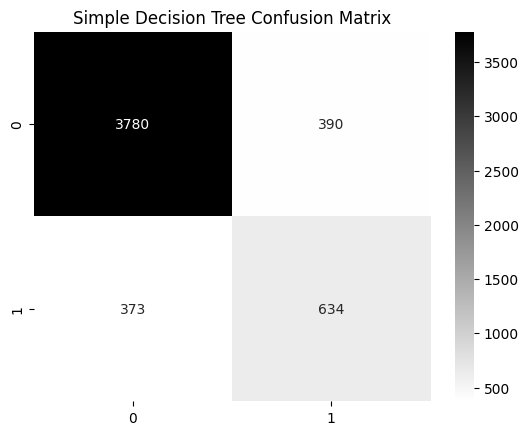

In [19]:
#Build confusion matrix for the simple model
simple_cf=sk.metrics.confusion_matrix(y_test,simple_tree_preds)
sns.heatmap(simple_cf, annot=True, cmap="binary",fmt=".0f")
plt.title('Simple Decision Tree Confusion Matrix')
plt.show()

In [54]:
#Compute metrics for Simple Model
dt_pr=round(sk.metrics.precision_score(y_test,simple_tree_preds),3)
dt_re=round(sk.metrics.recall_score(y_test,simple_tree_preds),3)
dt_f1=round(sk.metrics.f1_score(y_test,simple_tree_preds),3)
dt_acc=round(sk.metrics.accuracy_score(y_test,simple_tree_preds),3)

print('The precision of the Simple Tree is: ', dt_pr)
print('The recall of the Simple Tree is: ', dt_re)
print('The F1 Score of the Simple Tree is: ', dt_f1)
print('The accuracy of the Simple Tree is: ', dt_acc)

The precision of the Simple Tree is:  0.619
The recall of the Simple Tree is:  0.63
The F1 Score of the Simple Tree is:  0.624
The accuracy of the Simple Tree is:  0.853


### The AdaBoost Model
The hypertuned adaboost model showed modest improvements over the simple decision tree model with precision increasing the most, 12.7%. Recall, F1 Score and accuracy saw increases between 3.6%-4.4%. While the AdaBoost model was the nest performer, there is still ample room for improvement given that only 2/3 of seller markets were correctly identified.

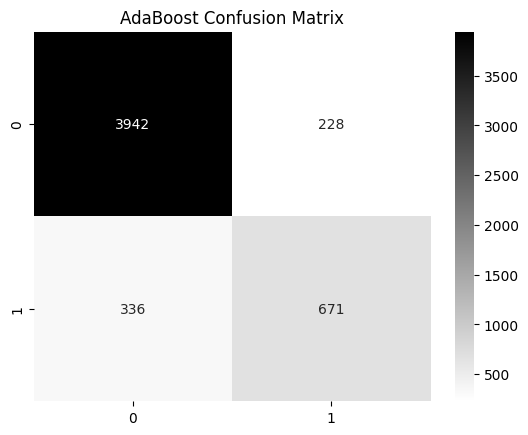

In [21]:
#Build confusion matrix for the adaboost model
ada_cf=sk.metrics.confusion_matrix(y_test,adatree_preds)
sns.heatmap(ada_cf, annot=True, cmap="binary", fmt=".0f")
plt.title('AdaBoost Confusion Matrix')
plt.show()

In [56]:
#Compute metrics for Adaboost Model
ada_pr=round(sk.metrics.precision_score(y_test,adatree_preds),3)
ada_re=round(sk.metrics.recall_score(y_test,adatree_preds),3)
ada_f1=round(sk.metrics.f1_score(y_test,adatree_preds),3)
ada_acc=round(sk.metrics.accuracy_score(y_test,adatree_preds),3)

print('The precision of the Ensemble is: ', ada_pr)
print('The recall of the Ensemble is: ', ada_re)
print('The F1 Score of the Ensemble Tree is: ', ada_f1)
print('The accuracy of the Ensemble Tree is: ', ada_acc)

The precision of the Ensemble is:  0.746
The recall of the Ensemble is:  0.666
The F1 Score of the Ensemble Tree is:  0.704
The accuracy of the Ensemble Tree is:  0.891


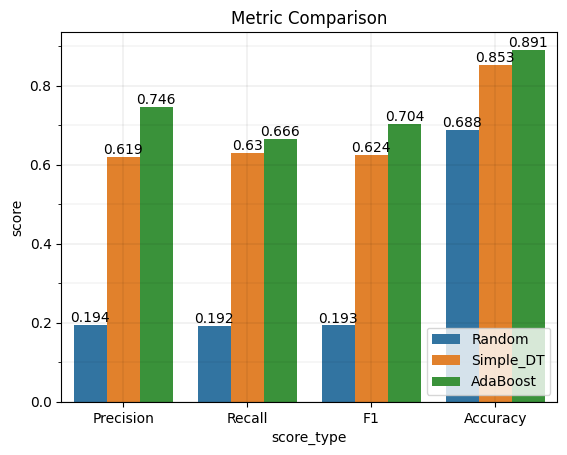

In [57]:
#Make a Summary Plot of all the Evaluation Metrics
metrics_dict={'model':['Random','Simple_DT','AdaBoost','Random','Simple_DT','AdaBoost','Random','Simple_DT','AdaBoost','Random','Simple_DT','AdaBoost'],
      'score_type':['Precision','Precision','Precision','Recall','Recall','Recall','F1','F1','F1','Accuracy','Accuracy','Accuracy'],
      'score':[rand_pr, dt_pr, ada_pr, rand_re, dt_re, ada_re, rand_f1, dt_f1, ada_f1, rand_acc, dt_acc, ada_acc],
}

metrics_df=pd.DataFrame(metrics_dict)

metrics_plot=sns.barplot(data=metrics_df, x="score_type", y="score", hue='model')
metrics_plot.set(title='Metric Comparison')
metrics_plot.legend(loc='lower right')
metrics_plot.set_yticks([.1, .3, .5, .7, .9], minor=True)
metrics_plot.grid(which='major', color='black', linewidth=0.075)
metrics_plot.grid(which='minor', color='black', linewidth=0.05)
for i in metrics_plot.containers:
    metrics_plot.bar_label(i,)

##Discussion and Conclusion
Both models significantly outperform a random probabilistic guess by all scoring metrics as summarized in the table above. As expected, the AdaBoost ensemble model outperformed the base decision tree. The most significant imporvemnt is the boost in precision, but there is also a moderate improvement to all other metrics. However, there is certainly still room for prediction improvement since the best model still misses when it is a sellers market 1/3 of the time. Prediction performace is likely limited due to lack of sellers market samples relative to buyers markets. Additionally, no features were found to be strongly correlated which suggests different feature selection might be neccesary in future work.

###Sources
1. Housing Data. Zillow. (2023, April 1). Retrieved April 17, 2023, from https://www.zillow.com/research/data/ 
2. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
3. Waskom, M. L., (2021). seaborn: statistical data visualization. Journal of Open Source Software, 6(60), 3021, https://doi.org/10.21105/joss.03021
4.  J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007.